<center> <h1> Enron Person of Interest Identification </h1> </center>
<center> <h4> Udacity Data Analyst Nanodegree P5 </h4> </center>

<h4> Dataset Background </h4>

The Enron email + financial dataset is a large trove of information regarding the Enron Corporation, an energy, commodities, and services company that infamously went bankrupt in December 2001 as a result of fradulent business practices. In the aftermath of the company's collapse, the Federal Energy Regulatory Commission released more 1.6 million emails sent and received by Enron executives in the years from 2000-2002 ([History of Enron])(https://en.wikipedia.org/wiki/Enron). After numerous complaints regarding the sensitive nature of the emails, the FERC redacted a large portion of the emails, but about 0.5 million remained [available to the public](https://www.technologyreview.com/s/515801/the-immortal-life-of-the-enron-e-mails/). The email + financial data contains all of the emails, meta data about the emails such as number received and sent for each individual, and financial information such as salary and stock options. (The dataset, along with several functions used in this report, is available on [Udacity's GitHub](https://github.com/udacity/ud120-projects).) The dataset has become a playground for machine learning practicioners eager to try to develop models that can identify persons of interests, defined as an individual who was eventually tried for fraud in the Enron investigation. The goal of this project was to develop a model that could pick out the POI's. I choose not to use the text of the email's themselves, but rather the metadata about the emails as well as the financial information. The ultimate objective of investigating the Enron dataset is to be able to predict cases of fraud or unsafe business practices far in advance, so those responsible can be punished, and those who are innocent are not harmed. Machine learning holds the promise to a world where there are no more Enrons, but let's not get ahead of ourselves just yet! 

<h2> Outlier Investigation and Data Cleaning </h2>

The first step is to load in the data and investigate it for any errors or outliers that need to be corrected or removed. The data is provided in the form of a dictionary, and I will convert it to a pandas dataframe for easier data manipulation. 

In [1]:
import sys
import pickle
sys.path.append("../tools/")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

payment_data = ['salary',
                'bonus',
                'long_term_incentive',
                'deferred_income',
                'deferral_payments',
                'loan_advances',
                'other',
                'expenses',                
                'director_fees', 
                'total_payments']

stock_data = ['exercised_stock_options',
              'restricted_stock',
              'restricted_stock_deferred',
              'total_stock_value']

email_data = ['to_messages',
              'from_messages',
              'from_poi_to_this_person',
              'from_this_person_to_poi',
              'shared_receipt_with_poi']
              
              
features_list = ['poi'] + payment_data + stock_data + email_data

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN', np.nan)
df = df[features_list]

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
poi                          146 non-null bool
salary                       95 non-null float64
bonus                        82 non-null float64
long_term_incentive          66 non-null float64
deferred_income              49 non-null float64
deferral_payments            39 non-null float64
loan_advances                4 non-null float64
other                        93 non-null float64
expenses                     95 non-null float64
director_fees                17 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
to_messages                  86 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float

From the info about the dataset, I can see that all the fields are floating point numbers except for the poi identification which is True/False. There are 146 rows in the dataframe which most likely mean there are 146 individuals. 

There are numerous NaNs in both the email and financial fields. According to the [official pdf documentation for the finacial (payment and stock) data](https://github.com/udacity/ud120-projects/blob/master/final_project/enron61702insiderpay.pdf), values of NaN represent 0 and not unknown quantities. However, for the email data, NaNs stand for unknown information. Therefore, I will replace any financial data that is NaN with 0 but will fill in the NaNs for the email data with the mean of the column grouped by person of interest. In other words, if a person has a NaN value for 'to_messages', and they are a person of interest, I will fill in that value with the mean value of 'to_messages' for a person of interest. If I chose to drop the NaNs, that would reduce the size of what is already a small dataset. As the quality of a machine learning model is proportional to the amount of data fed into it, I am hesitant to remove any information that could possibly be of use. 

In [3]:
from sklearn.preprocessing import Imputer

# Fill in the NaN payment and stock values with zero 
df[payment_data] = df[payment_data].fillna(0)
df[stock_data] = df[stock_data].fillna(0)

# Fill in the NaN email data with the mean of column grouped by poi/ non_poi
imp = Imputer(missing_values='NaN', strategy = 'mean', axis=0)

df_poi = df[df['poi'] == True];
df_nonpoi = df[df['poi']==False]

df_poi.ix[:, email_data] = imp.fit_transform(df_poi.ix[:,email_data]);
df_nonpoi.ix[:, email_data] = imp.fit_transform(df_nonpoi.ix[:,email_data]);
df = df_poi.append(df_nonpoi);

c:\users\wkoehrse\appdata\local\continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


One simple way to check for outliers/incorrect data is to add up all of the payment related columns for each person and see if that is equal to the total payment recorded for the individual. I can also do the same for stock payments. If the data was entered by hand, I would expect that there may be a few errors that I can correct by comparing to the official PDF prepared by FineLaw. 

In [4]:
errors = (df[df[payment_data[:-1]].sum(axis='columns') != df['total_payments']])
errors

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
BELFER ROBERT,False,0.0,0.0,0.0,0.0,-102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0,0.0,44093.0,-44093.0,2007.111111,668.763889,58.5,36.277778,1058.527778
BHATNAGAR SANJAY,False,0.0,0.0,0.0,0.0,0.0,0.0,137864.0,0.0,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,523.000000,29.000000,0.0,1.000000,463.000000


Sure enough, there are two individuals for which the sum of their different payments does not add up to the recorded total payment. 
The errors appear to be caused by a misalignment of the columns; for Robert Belfer, the financial data has been shifted one column to the right, and for Sanjay Bhatnagar, the data has been shifted one column to the left. I can shift the columns to their correct positions and then check again to see if the individual payment and stock values add up to the respective totals.

In [5]:
# Retrieve the incorrect data for Belfer
belfer_financial = df.ix['BELFER ROBERT', 1:15].tolist()
# Delete the first element to shift left and add on a 0 to end as indicated in financial data
belfer_financial.pop(0)
belfer_financial.append(0)
# Reinsert corrected data
df.ix['BELFER ROBERT', 1:15] = belfer_financial

# Retrieve the incorrect data for Bhatnagar
bhatnagar_financial = df.ix['BHATNAGAR SANJAY', 1:15].tolist()
# Delete the last element to shift right and add on a 0 to beginning
bhatnagar_financial.pop(-1)
bhatnagar_financial = [0] + bhatnagar_financial
# Reinsert corrected data
df.ix['BHATNAGAR SANJAY', 1:15] = bhatnagar_financial

In [6]:
# Check for any more errors with the payment data
len(df[df[payment_data[:-1]].sum(axis='columns') != df['total_payments']])

0

In [7]:
# Check for any errors with the stock data
len(df[df[stock_data[:-1]].sum(axis='columns') != df['total_stock_value']])

0

Correcting the shifted financial data eliminated two errors. However, there may still be outliers in the dataset that need to be removed. Looking through the official financial PDF, I can see that I need to remove 'TOTAL' as it is currently the last row of the dataframe and it will throw off any predictions (even though this is correct data, it is not a person and will be of no value when trying to identify persons of interest). Likewise, there is an entry for 'THE TRAVEL AGENCY IN THE PARK', which according to the documentation, was a company co-owned by Enron's former Chairman's sister and is clearly not an individual that should be included in the dataset.  

In [8]:
df.drop(axis=0, labels=['TOTAL','THE TRAVEL AGENCY IN THE PARK'], inplace=True)

I can now look for outlying data points recorded in the different fields. However, I will be conservative in terms of removing the outliers because the dataset is rather small for machine learning in the first place. Moreover, the outliers might actually be important as they could represent patterns in the data that would aid in the identification of persons of interest. The [official definition of a mild outlier](http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm) is either below the (first quartile  minus 1.5 times the Interquartile Range (IQR))  or  above the (third quartile plus 1.5 times the IQR). My approach will be to count the number of outlying features each individual has in the dataset. I will then investigate these outliers to determine if any should be removed. 

In [9]:
IQR = df.quantile(q=0.75) - df.quantile(q=0.25)
first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
outliers = df[(df>(third_quartile + 1.5*IQR) ) | (df<(first_quartile - 1.5*IQR) )].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers.head(12)

LAY KENNETH L         15
FREVERT MARK A        12
BELDEN TIMOTHY N       9
SKILLING JEFFREY K     9
BAXTER JOHN C          8
LAVORATO JOHN J        8
DELAINEY DAVID W       7
KEAN STEVEN J          7
HAEDICKE MARK E        7
WHALLEY LAWRENCE G     7
RICE KENNETH D         6
KITCHEN LOUISE         6
dtype: int64

As this point, I need to do some research before blinding deleting outliers. Based on the small number of persons of interest initially in the dataset, I decided to not remove any individuals who are persons are interest regardless of the number of outliers they may have. An outlier could be a sign of fradulent activity, as it could be evidence that someone is laundering illegal funds through the company payroll or perhaps an accomplice is being paid to remain silent. I will examine several of the top outlying inviduals out of curiousity. 

A few interesting observations about the outliers:

1. Kenneth Lay, [the CEO of Enron from 1986-2001](http://www.biography.com/people/kenneth-lay-234611), presided over many of the illegal business activites and hence is one of the most important persons of interest. 
2. Mark Frevert served as chief executive of [Enron Europe from 1986-2000 and was appointed as chairman of Enron in 2001](http://www.risk.net/risk-management/2123422/ten-years-after-its-collapse-enron-lives-energy-markets). He was a major player in the firm, although not a person of interest. I believe that he is not representative of the average employee at Enron during this time because of his substantial compensation and will remove him from the dataset. 
3. Timothy Belden was the [former head of trading for Enron](http://articles.latimes.com/2007/feb/15/business/fi-enron15) who developed the strategy to illegally raise energy prices in California. He was a person of interest and will definitely remain in the dataset. 
4. Jeffrey Skilling [replaced Kenneth Lay as CEO of Enron in 2001 and orchestrated much of the fraud](http://www.biography.com/people/jeffrey-skilling-235386) that destroyed Enron. As a person of interest, he will remain in the dataset. 
5. John Baxter was a former vice Enron vice chairman and [died of an apparent self-inflicted gunshot](https://www.wsws.org/en/articles/2002/01/enro-j28.html) before he was able to testify against other Enron executives. I will remove him from the dataset as he is not a person of interest. 
6. John Lavorato was a top executive in the energy-trading branch of Enron and received large bonuses to [keep him from leaving Enron](http://www.nytimes.com/2002/06/18/business/officials-got-a-windfall-before-enron-s-collapse.html). As he was not a person of interest, and the large bonus ended up skewing his total pay towards the top of the range, I think it would be appropriate to remove him from the dataset. 
7. Lawrence Whalley [served as the president of Enron](http://www.corpwatch.org/article.php?id=13194) and fired Andrew Fastow once it was apparent the severity of Enron's situation. He was investigated thoroughly but not identified as a person of interest and therefore will be removed from the dataset.  

Total, I decided to remove four people from the dataset. I believe these removals are justified primarily because none of these individuals were persons of interest and they all were upper-level executives with pay levels far above the average employee. I do not think these top executives who did not commit fraud are indicative of the majority of employees at Enron who also did not commit fraud (i.e. they were not persons of interest). 

In [10]:
# Remove the outlier individuals
df.drop(axis=0, labels=['FREVERT MARK A', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G', 'BAXTER JOHN C'], inplace=True)

In [11]:
len(df)

140

In [12]:
# Find the number of poi and non poi now in the data
df['poi'].value_counts()

False    122
True      18
Name: poi, dtype: int64

In [13]:
df.isnull().sum().sum()

0

In [14]:
df[df==0].count().sum()

1150

There are a total of 2800 observations of financial and email data in the set now that the data cleaning has been finished. Of these, __1150 or 41%__ are 0 for financial (payment and stock) values. There are 18 persons of interest, comprising __12.9%__ of the individuals. 

<h2> First Algorithm Testing and Performance Metrics </h2>

I now want to try training some algorithms on all of the initial features in the dataset to gauge the importance of features and to see what the accuracy is like without any parameter tuning. 
The four algorithms I have selected for initial testing are Gaussian Naive Bayes (GaussianNB), DecisionTreeClassifier, Support Vector Classifier (SVC), and KMeans Clustering. I will run the algorithms with the default parameters except I will alter the kernel used in the Support Vector Machine to be linear. I will also select number of clusters = 2 for KMeans as I know in advance that there are two categories that should be classified by the model. Although accuracy would appear to be the obvious choice for evaluating the quality of a classifier, accuracy can be a crude measure at times, and is not suited for some datasets including this one. For example, if a classifier were to guess that all of the samples in the cleaned dataset were _not_ persons of interest, it would have an accuracy of 87.1%. However, this clearly would not satisfy the objective of this investigation which is to create a classifier that can identify _persons of interest_. Therefore, different metrics are needed to evaluate the tuned algorithm to gauge its effectiveness. The two selected for this project are [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall).

* __Precision__ is the number of correct positive classifications divided by the total number of positive labels assigned. In other words, it is the fraction of persons of interest predicted by the algorithm that are truly persons of interest.  Mathematically precision is defined as 

$$ precision = \frac{true\ positives}{true\ positives + false\ positives} $$

* __Recall__ is the number of correct positive classifications divided by the number of positive instances that should have been identified. In other words, it is the fraction of the total number of persons of interest that the classifier identifies. Mathematically, recall is defined as

\\[ recall = \frac{true\ positives}{true\ positives + false\ negatives} \\]

Precision is also known as positive predictive value while recall is the sensitivity of the classifier. A combined measured of precision and recall is the [__F1 score__](https://en.wikipedia.org/wiki/F1_score). Is it the harmonic mean of precision and recall. Mathematically, the F1 score is defined as:

\\[ F1\ Score = \frac{2\ (precision\ x\ recall)}{precision + recall} \\]

For this project, the objective was a precision and a recall both greater than 0.3. However, I believe it is possible to do much better than that with the right feature selection and algorithm tuning. 

<h4> Scaling </h4>

The only preparation I will do for this initial testing of the different algorithms is to scale the data such that it has a zero mean and a unit variance. This process is called [normalization](http://www.analytictech.com/ba762/handouts/normalization.htm) and is accomplished using the scale function from the sklearn preprocessing module. Scaling of some form (whether that is MinMax scaling or normalization) is usually necessary because there are different units for the features in the dataset and this process is able to create non-dimensional features. If the features are not scaled, those with a larger units can have an undue influence on the classifier, especially if the classifier uses some sort of measurement (such as Euclidean distance) in order to make predictions. [Here is a good dicussion of feature scaling and normalization](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data). 

In [15]:
from sklearn.preprocessing import scale
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
import tester

# Scale the dataset and send it back to a dictionary
scaled_df = df.copy()
scaled_df.ix[:,1:] = scale(scaled_df.ix[:,1:])
my_dataset = scaled_df.to_dict(orient='index')

# Create and test the Gaussian Naive Bayes Classifier
clf = GaussianNB()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

	Accuracy: 0.70714	Precision: 0.30909	Recall: 0.85000	F1: 0.45333	F2: 0.62963
	Total predictions:  140	True positives:   17	False positives:   38	False negatives:    3	True negatives:   82



In [16]:
# Create and test the Decision Tree Classifier
clf = DecisionTreeClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

	Accuracy: 0.82857	Precision: 0.40000	Recall: 0.40000	F1: 0.40000	F2: 0.40000
	Total predictions:  140	True positives:    8	False positives:   12	False negatives:   12	True negatives:  108



In [17]:
# Create and test the Support Vector Classifier
clf = SVC(kernel='linear')
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.86429	Precision: 0.57143	Recall: 0.20000	F1: 0.29630	F2: 0.22989
	Total predictions:  140	True positives:    4	False positives:    3	False negatives:   16	True negatives:  117



In [18]:
# Create and test the K Means clustering classifier
clf = KMeans(n_clusters=2)
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

	Accuracy: 0.71429	Precision: 0.11538	Recall: 0.15000	F1: 0.13043	F2: 0.14151
	Total predictions:  140	True positives:    3	False positives:   23	False negatives:   17	True negatives:   97



The results from running the four classifiers on the entire featureset with no algorithm tuning are summarized in the table below

| Classifier            | Precision | Recall  | F1 Score | Accuracy |
|-----------------------|-----------|---------|----------|----------|
| GaussianNB            | 0.30909   | 0.85000 | 0.45333  | 0.70714  |
| DecisionTree          | 0.5000    | 0.45000 | 0.47368  | 0.85714  |
| SVC (kernel='linear') | 0.57143   | 0.2000  | 0.29630  | 0.86429  |
| KMeans (n_clusters=2) | 0.17647   | 0.15000 | 0.16216  | 0.77857  |

From the first run through the four algorithms, I can see that the decision tree performed best, followed by the gaussian naive bayes, support vector machine, and Kmeans clustering. In fact, the decision tree and naive Bayes classifiers both perform well enough to meet the standards for the project. Nonetheless, there is much work that can be done to improve these metrics. 

<h2> A Quick Note on Validation </h2> 

The validation strategy I am using here is a form of cross-validation that is implemented in the provided tester.py script. [Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) performs multiple splits on the dataset and in each split, forms a different training and testing set. Each iteration, the classifier is fit on a training set and then tested on a testing set. The next iteration the classifier is again trained and tested, but on different sets and this process continues for the number of splits made of the dataset. Cross-validation prevents me from making the classic mistake of training an algoithm on the same data used to test the algorithm. If this happens, the test results may show that the classifier is accurate, but that is only because the algorithm has seen the testing data before. When the classifier is deployed on novel samples, the performance may be poor because it was trained and tuned for a very specific set of instances. The classifier will not be able to generalize to new cases becuase it is only fit and tuned to the specific samples it is trained and tested on. Cross-validation solves this issue by training and testing on multiple different subsets of the features and labels and is ideal for use on small datasets. Throughout my analysis, I used cross-validation to assess the performance of my algorithms. The tester.py script uses the [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) cross-validation method, and GridSearchCV, which is used to find the optimal number of features and the best parameters employs cross validation with the StratifiedKFolds method. In both cases, the number of splits of the dataset is 10. 

<h1> Feature Engineering </h1>

Although the decision tree algorithm already performs above the standard for precision and recall, I want to create new features that could possibly improve performance. I will also need to carry out feature selection to remove those features that are not useful for predicting a person of interest. 

After thinking over the background of the Enron case and the information contained in the dataset, I thought of three new features to create from the email meta data. The first will be the ratio of emails to an individual from a person of interest to all emails addressed to that person, the second is the same but for messages to persons of interest, and the third will be the ratio of email receipts shared with a person of interest to all emails addressed to that individual. The rational behind these choices is that the absolute number of emails from or to a person of interest might not matter so much as the relative number when scaled by the total emails an individual sends or receives. My instinct says that individuals who interact more with a person of interest are themselves more likely to be a person of interest because the fraud was not perpertrated alone and required a net of individuals. However, there are also some innocent persons who may have sent or received many emails from persons of interest simply in the course of their daily (perfectly above the table) work. 

In [19]:
# Add the new email features to the dataframe
df['to_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df['from_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']
df['shared_poi_ratio'] = df['shared_receipt_with_poi'] / df['to_messages']

In [20]:
features_list.append('to_poi_ratio')
features_list.append('from_poi_ratio')
features_list.append('shared_poi_ratio')

At this point I will also create new features using the financial data. I have a few theories that I formed from my initial data exploration and reading about the Enron case. I think that people recieving large bonuses may be more likely to be persons of interest becuase the bonuses could be a result of fraudulent activity, or perhaps a bribe to keep someone quiet. Whatever the case may be, I will create two new features that are the bonus in relation to the salary, and the bonus in relation to total payments. There are now a total of 25 features, some of which are most likely redudant or not of any value. However, I will perform feature reduction/selection eventually so I am not worried about the large number of features. Moreover the algorithms I am using are able to train relatively quickly even with the large number of features because the total amount of data samples is small. 

In [21]:
# Create the new financial features and add to the dataframe
df['bonus_to_salary'] = df['bonus'] / df['salary']
df['bonus_to_total'] = df['bonus'] / df['total_payments']                  

In [22]:
features_list.append('bonus_to_salary')
features_list.append('bonus_to_total')   

After adding in the additional five features, I want to retest all of the algorithms. I will use the same tester.py script that implements cross validation to assess the precision and recall of the classifiers. 

In [23]:
# Fill any NaN financial data with a 0
df.fillna(value= 0, inplace=True)

# Create a copy of the dataframe and normalize it to zero mean and unit variance
scaled_df = df.copy()
scaled_df.ix[:,1:] = scale(scaled_df.ix[:,1:])

# Send the dataset from dataframe to dictionary for tester.py
my_dataset = scaled_df.to_dict(orient='index')

# Create the classifier, GaussianNB has no parameters to tune
clf = GaussianNB()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.72857	Precision: 0.32000	Recall: 0.80000	F1: 0.45714	F2: 0.61538
	Total predictions:  140	True positives:   16	False positives:   34	False negatives:    4	True negatives:   86



In [24]:
clf = DecisionTreeClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.89286	Precision: 0.63158	Recall: 0.60000	F1: 0.61538	F2: 0.60606
	Total predictions:  140	True positives:   12	False positives:    7	False negatives:    8	True negatives:  113



In [25]:
clf = SVC(kernel='linear')
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.83571	Precision: 0.33333	Recall: 0.15000	F1: 0.20690	F2: 0.16854
	Total predictions:  140	True positives:    3	False positives:    6	False negatives:   17	True negatives:  114



In [26]:
clf = KMeans(n_clusters=2)
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.85000	Precision: 0.40000	Recall: 0.10000	F1: 0.16000	F2: 0.11765
	Total predictions:  140	True positives:    2	False positives:    3	False negatives:   18	True negatives:  117



After adding in the features, the results for all of the algorithms improved and are summarized below:

| Classifier            | Precision | Recall  | F1 Score | Accuracy |
|-----------------------|-----------|---------|----------|----------|
| GaussianNB            | 0.35556   | 0.80000 | 0.49321  | 0.76429  |
| DecisionTree          | 0.60000   | 0.60000 | 0.60000  | 0.88571  |
| SVC (kernel='linear') | 0.71429   | 0.25000 | 0.37037  | 0.87857  |
| KMeans (n_clusters=2) | 0.12500   | 0.25000 | 0.16667  | 0.64286  |

The F1 score for the decision tree is stil the highest followed by the Gaussian Naive Bayes. At this point, neither the SVC with the linear kernel nor the KMeans clustering pass the standards of 0.3 for precision and recall. I will drop the latter two algorithms and I will also drop the GaussianNB in favor of the [AdaBoost Classifier](http://rob.schapire.net/papers/explaining-adaboost.pdf) because I want to experiment with tunable parameters and has GaussianNB has none. AdaBoost takes a weak classifier, and trains it multiple times on a dataset, each run adjusting the weights of incorrectly classified instances to concentrate on the most difficult to classify samples. AdaBoost works on top on a weak existing classifier in an iterative manner and can be used in conjuction with the DecisionTree or GaussianNB.  

In order to understand the features I have, I want to visualize some of the data. Perhaps it could help me select features or see if there are noticeable trends in the data. The following is a simple scatterplot of the email ratio features I created and the bonus ratios I created. For the email ratios, my intuition tells me that persons of interest would tend to have points higher in both ratios and therefore they should tend to be located in the upper right of the plot. For the bonus ratios, I would expect much the same behavior. As can be seen however, that is not exactly the case. In both plots it appear that the nonpersons of interest are clustered to the bottom left, but there is not a clear trend among the persons of interest. I also noticed the odd point that several of the bonus to total ratios are greater than one. I thought this might be an error in the dataset, but after looking at the official financial data document, I saw some individuals did indeed have larger bonuses than their total payments because they had negative values in other payment categories. There are no firm conclusions to draw from these graphs, but it does appear that the new features might be of some use in identifiying persons of interest. 

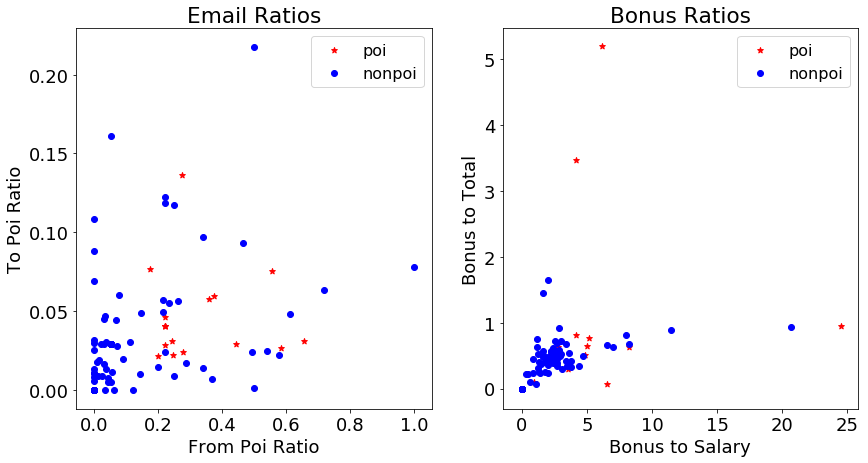

In [92]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
poi_df = df[df['poi']==True]
nonpoi_df = df[df['poi']==False]

plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
plt.scatter(x=poi_df['from_poi_ratio'], y = poi_df['to_poi_ratio'], color = 'red', marker='*')
plt.scatter(x=nonpoi_df['from_poi_ratio'], y = nonpoi_df['to_poi_ratio'], color = 'blue')
plt.xlabel('From Poi Ratio'); plt.ylabel('To Poi Ratio'); plt.title('Email Ratios'); 
plt.legend(['poi', 'nonpoi'], prop= {'size': 16})

ax2 = fig.add_subplot(122)
plt.scatter(x=poi_df['bonus_to_salary'], y = poi_df['bonus_to_total'], color = 'red', marker='*')
plt.scatter(x=nonpoi_df['bonus_to_salary'], y = nonpoi_df['bonus_to_total'], color = 'blue')
plt.xlabel('Bonus to Salary'); plt.ylabel('Bonus to Total'); plt.title('Bonus Ratios');
plt.legend(['poi', 'nonpoi'], prop= {'size': 16});


The plot below is a scatter matrix showing all the relationships between four selected features: 'bonus', 'total_payments', 'to_poi_ratio', and 'from_poi_ratio'. The diagonals are histograms because a variable correlated with itself is simply one. The persons of interest are plotted in yellow and the non persons of interest are the purple points. Overall, there do seem to be a couple of trends. Looking at the bonus vs from_poi_ratio, the persons of interest tend to be further to the right and above the non persons of interest. This indicates that persons of interest tend to recieve larger bonuses and they send more emails to other persons of interest. The scale on the total payments graph makes those graphs somewhat difficult to read but it can be seen that persons of interest tend to have higher total payments. In the to_poi_ratio vs total_payments this trend can be observed. This could show that persons of interest recieve more total payments because of their fraudulent activity or because they tend to be higher in the company and are therefore paid greater amounts. 

Overall, the visualizations do not offer many clear trends. However, it is still important to get a feel for the scale of the data and to check and see if there are any patterns evident that could inform the creation of new features. A great visualization of the Enron email and financial dataset is available as a [navigable dashboard](https://public.tableau.com/profile/diego2420#!/vizhome/Udacity/UdacityDashboard). 

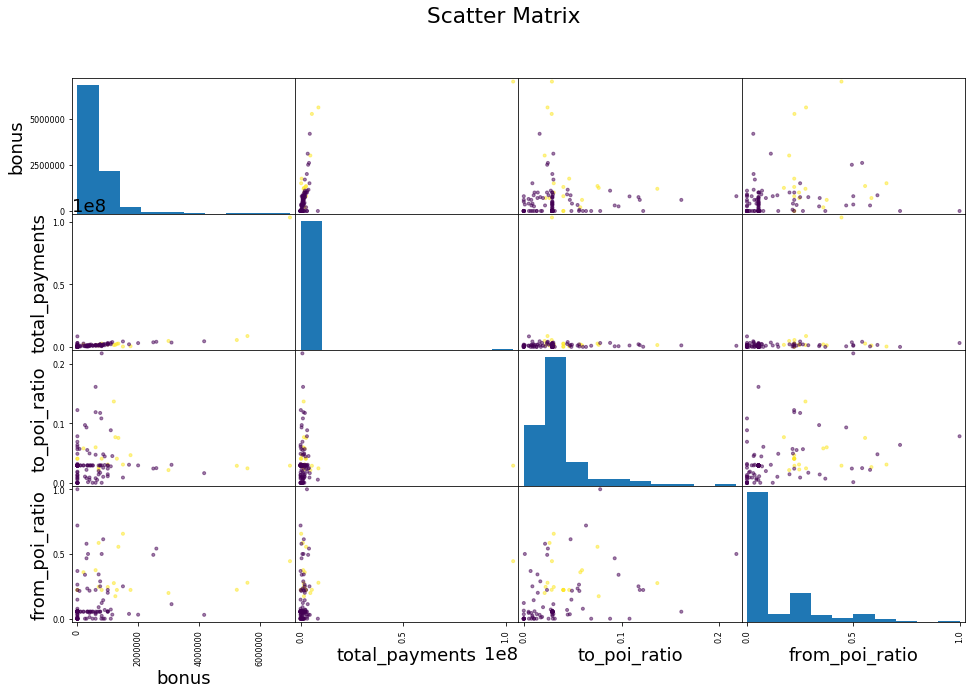

In [107]:
from pandas.tools.plotting import scatter_matrix
features_to_plot = ['bonus',  'total_payments', 'to_poi_ratio', 'from_poi_ratio']
scatter_matrix(df[features_to_plot], figsize=(16,10), c=df['poi']);
plt.suptitle('Scatter Matrix');

<h1> Feature Selection </h1> 

There are several methods available for performing feature selection. One is simply to look at the feature importances for a classifier and modify the list of features to exclude those with an importance below a chosen threshold. Another is to use [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) and have the k-best features automatically selected for use in the classifier. I will look at the feature importances for both the DecisionTree and the AdaBoost Classifier, but I would prefer to use SelectKBest to actually choose the features to keep. Additionally, I can use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) in combination with SelectKBest to find the optimal number of features to use. This will run through a number of k values and choose the one that yields the highest value according to a performance metric. 

First, I will manually look at the feature importances for both classifiers to get a sense of which features are most important. One of the neat concepts about machine learning is that it can help humans to think smarter. By looking at what the algorithm chooses as the most important features to identify persons of interest, it can inform humans what they should be looking for in similar cases. (One example of this in the real world is when Google's AlphaGo defeated Lee Sedol in Go, it advanced the entire state of Go by providing new [insights and strategies](https://www.youtube.com/watch?v=dTGthmNmrK4) into a game humans have played for millenia.)

In [28]:
clf_tree = DecisionTreeClassifier()
clf_tree = tester.test_classifier(clf_tree, my_dataset, features_list)

	Accuracy: 0.90000	Precision: 0.65000	Recall: 0.65000	F1: 0.65000	F2: 0.65000
	Total predictions:  140	True positives:   13	False positives:    7	False negatives:    7	True negatives:  113



In [29]:
# Get the feature importances of the DecisionTree Classifier
tree_feature_importances = (clf_tree.feature_importances_)
tree_features = zip(tree_feature_importances, features_list[1:])
tree_features = sorted(tree_features, key= lambda x:x[0], reverse=True)

# Display the feature names and importance values
print('Tree Feature Importances:\n')
for i in range(10):
    print('{} : {:.4f}'.format(tree_features[i][1], tree_features[i][0]))

Tree Feature Importances:

from_poi_ratio : 0.3782
shared_receipt_with_poi : 0.2485
expenses : 0.2476
shared_poi_ratio : 0.0665
from_poi_to_this_person : 0.0592
salary : 0.0000
bonus : 0.0000
long_term_incentive : 0.0000
deferred_income : 0.0000
deferral_payments : 0.0000


In [30]:
clf_ada = AdaBoostClassifier()
clf_ada = tester.test_classifier(clf_ada, my_dataset, features_list);

	Accuracy: 0.94286	Precision: 0.83333	Recall: 0.75000	F1: 0.78947	F2: 0.76531
	Total predictions:  140	True positives:   15	False positives:    3	False negatives:    5	True negatives:  117



In [31]:
# Get the feature importances for the AdaBoost Classifier
ada_feature_importances = clf_ada.feature_importances_
ada_features = zip(ada_feature_importances, features_list[1:])

# Display the feature names and importance values
print('Ada Boost Feature Importances:\n')
ada_features = sorted(ada_features, key=lambda x:x[0], reverse=True)
for i in range(10):
    print('{} : {:.4f}'.format(ada_features[i][1], ada_features[i][0]))

Ada Boost Feature Importances:

shared_receipt_with_poi : 0.1200
exercised_stock_options : 0.1000
from_this_person_to_poi : 0.1000
to_poi_ratio : 0.1000
deferred_income : 0.0800
from_messages : 0.0800
from_poi_ratio : 0.0800
other : 0.0600
total_stock_value : 0.0600
shared_poi_ratio : 0.0400


It is interesting to compare the feature importances for the DecisionTree and the AdaBoost classifiers. The top 10 features are not in close agreement for the top ten even though both classifiers achieve a respectable F1 Score greater than 0.5. However, rather than manually selecting the features to keep, I will use GridSearchCV to find the optimal number of features for the classifiers. GridSearchCV runs through a parameter grid and tests all the different configurations provided to it. It returns the parameters that yield the maximum score. I will use a scoring parameter of F1 because that is what I would like to maximize, and a cross-validation with 10 splits to ensure that I am not overfitting the algorithm to the training data. 

In [32]:
from feature_format import featureFormat, targetFeatureSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

data_dict = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data_dict)

In [33]:
from sklearn.model_selection import GridSearchCV

n_features = np.arange(1, len(features_list))

# Create a pipeline with feature selection and classification
pipe = Pipeline([
    ('select_features', SelectKBest()),
    ('classify', DecisionTreeClassifier())
])

param_grid = [
    {
        'select_features__k': n_features
    }
]

# Use GridSearchCV to automate the process of finding the optimal number of features
tree_clf= GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv = 10)
tree_clf.fit(features, labels);


c:\users\wkoehrse\appdata\local\continuum\anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
tree_clf.best_params_

{'select_features__k': 17}

According to the grid search performed with SelectKBest with the number of features ranging from 1 to the number of features, the __optimal number of features for the decision tree classifier is 19__. I can look at the scores assigned to the top performing features using the scores attribute of SelectKBest.

In [35]:
tree_selection = SelectKBest(k=19)
tree_selection.fit_transform(features, labels)

tree_scores = tree_selection.scores_
tree_features = zip(tree_scores, features_list[1:])
tree_features = sorted(tree_features, key= lambda x:x[0], reverse=True)

print('Tree Feature F-statistics:\n')
for i in range(19):
    print('{} : {:.4f}'.format(tree_features[i][1], tree_features[i][0]))

Tree Feature F-statistics:

bonus : 36.2022
from_poi_ratio : 25.8246
salary : 25.4609
total_stock_value : 24.8372
exercised_stock_options : 24.0888
bonus_to_total : 20.8908
deferred_income : 17.0963
bonus_to_salary : 17.0251
shared_poi_ratio : 16.1635
shared_receipt_with_poi : 14.7385
from_poi_to_this_person : 12.9213
long_term_incentive : 12.7397
total_payments : 10.2104
restricted_stock : 10.0832
other : 7.9157
loan_advances : 7.0635
expenses : 5.7008
from_this_person_to_poi : 3.4099
to_poi_ratio : 2.8564


The SelectKBest defaults to scoring parameters using the [ANOVA F-value](http://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test) which is a measure of variation between sample means. It describes how much of the variance between labels is explained by a particular feature. A higher value therefore means that there is more variation in that feature between person of interests and non persons of interest. The following table summarizes the Decision Tree features and the ANOVA F-Value returned by SelectKBest with k = 19. These are the features I used in my final DecisionTreeClassifier. Here are the features as well as their f-statistic score:

| Feature                 | F-statistic |
|-------------------------|-------------|
| bonus                   | 36.2        |
| from_poi_ratio          | 25.8        |
| salary                  | 25.5        |
| total_stock_value       | 24.8        |
| exercised_stock_options | 24.1        |
| bonus_to_total          | 20.9        |
| deferred_income         | 17.1        |
| bonus_to_salary         | 17.0        |
| shared_poi_ratio        | 16.2        |
| shared_receipt_with_poi | 14.7        |
| from_poi_to_this_person | 12.9        |
| long_term_incentive     | 12.7        |
| total_payments          | 10.2        |
| restricted_stock        | 10.1        |
| other                   | 7.92        |
| loan_advances           | 7.06        |
| expenses                | 5.70        |
| from_this_person_to_poi | 3.41        |
| to_poi_ratio            | 2.86        |

In [36]:
tree_clf = Pipeline([
    ('select_features', SelectKBest(k=19)),
    ('classify', DecisionTreeClassifier()),
])

tester.dump_classifier_and_data(tree_clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.92143	Precision: 0.71429	Recall: 0.75000	F1: 0.73171	F2: 0.74257
	Total predictions:  140	True positives:   15	False positives:    6	False negatives:    5	True negatives:  114



Running the DecisionTreeClassifier with SelectKMeans and k = 19 yields an F1 score of 0.700. I am very pleased with that result and have decided on the 19 features that I will use with the DecisionTreeClassifier. Any further improvement from this algorithm will come in the parameter tuning section of the investigation.

A similar procedure with GridSearchCV and SelectKBest will be carried out to determine the optimal number of features to use with the AdaBoostClassifier. 

In [37]:
n_features = np.arange(1, len(features_list))
# Create a pipeline of feature selection and classifier
pipe = Pipeline([
    ('select_features', SelectKBest()),
    ('classify', AdaBoostClassifier())
])

param_grid = [
    {
        'select_features__k': n_features
    }
]

# Use GridSearchCV to automate the process of finding the optimal number of features
ada_clf= GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv =10)
ada_clf.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x000000000A03BF98>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [38]:
ada_clf.best_params_

{'select_features__k': 23}

In [39]:
ada_clf.best_score_

0.65952380952380951

In [40]:
ada_selection = SelectKBest(k=23)
ada_selection.fit_transform(features, labels)

ada_scores = ada_selection.scores_
ada_features = zip(ada_scores, features_list[1:])
ada_features = sorted(ada_features, key= lambda x:x[0], reverse=True)

print('AdaBoost Features F-statistics:\n')
for i in range(23):
    print('{} : {:.4f}'.format(ada_features[i][1], ada_features[i][0]))

AdaBoost Features F-statistics:

bonus : 36.2022
from_poi_ratio : 25.8246
salary : 25.4609
total_stock_value : 24.8372
exercised_stock_options : 24.0888
bonus_to_total : 20.8908
deferred_income : 17.0963
bonus_to_salary : 17.0251
shared_poi_ratio : 16.1635
shared_receipt_with_poi : 14.7385
from_poi_to_this_person : 12.9213
long_term_incentive : 12.7397
total_payments : 10.2104
restricted_stock : 10.0832
other : 7.9157
loan_advances : 7.0635
expenses : 5.7008
from_this_person_to_poi : 3.4099
to_poi_ratio : 2.8564
director_fees : 2.1897
to_messages : 1.0279
from_messages : 0.9875
restricted_stock_deferred : 0.7876


In [41]:
tester.dump_classifier_and_data(ada_clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.92857	Precision: 0.77778	Recall: 0.70000	F1: 0.73684	F2: 0.71429
	Total predictions:  140	True positives:   14	False positives:    4	False negatives:    6	True negatives:  116



The ideal number of parameters for SelectKMeans using GridSearch for the AdaBoostClassifier was 23. This resulted in a slightly lower F1 score of 0.689, but still quite high. I will use the 23 highest scoring features with the AdaBoostClassifier. The F-Scores are the same so I will not show them all again. 

At this point I could also perform Principal Component Analysis, but I think that the performance I am seeing is already high and the algorithms do not take very long to train even on a large number of features. PCA creates new features that do not necessarily represent actual quantifiable values in the dataset, and I like the idea that I know exactly all the features I am putting into the model. This is one way that I try to combat the [black box problem](http://www.nature.com/news/can-we-open-the-black-box-of-ai-1.20731) in machine learning. If I at least know what is going in, then I can try to understand why the model returned a certain classification and maybe it can inform my thinking and help me to create smarter machine learning models. 

<h1> Algorithm Tuning </h1>

The next step is to begin tuning the classifiers. I will use GridSearchCV again and I will input a wide variety of parameters to try in the parameter grid. The decision tree classifier will be up first. Looking at the sci-kit learn [documentation for the DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), there are a number of parameters that can be tuned and I will focus on four. The first will be __criterion__ for splitting, either 'gini', or 'entropy' to maximize the [information gain](https://en.wikipedia.org/wiki/Information_gain_ratio). The other three I will try will be __min_samples_split__, __max_depth__, and __max_features__. I will continue to use a cross-validation with 10 splits in the grid search and the scoring criterion will remain set at F1 because that is what I am trying to maximize.`

In [42]:
# Create a pipeline with feature selection and classifier
tree_pipe = Pipeline([
    ('select_features', SelectKBest(k=19)),
    ('classify', DecisionTreeClassifier()),
])

# Define the configuration of parameters to test with the 
# Decision Tree Classifier
param_grid = dict(classify__criterion = ['gini', 'entropy'] , 
                  classify__min_samples_split = [2, 4, 6, 8, 10, 20],
                  classify__max_depth = [None, 5, 10, 15, 20],
                  classify__max_features = [None, 'sqrt', 'log2', 'auto'])

# Use GridSearchCV to find the optimal hyperparameters for the classifier
tree_clf = GridSearchCV(tree_pipe, param_grid = param_grid, scoring='f1', cv=10)
tree_clf.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=19, score_func=<function f_classif at 0x000000000A03BF98>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__max_features': [None, 'sqrt', 'log2', 'auto'], 'classify__min_samples_split': [2, 4, 6, 8, 10, 20], 'classify__criterion': ['gini', 'entropy'], 'classify__max_depth': [None, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [43]:
tree_clf.best_score_

0.82190476190476203

In [44]:
# Get the best algorithm hyperparameters for the Decision Tree
tree_clf.best_params_

{'classify__criterion': 'entropy',
 'classify__max_depth': None,
 'classify__max_features': None,
 'classify__min_samples_split': 20}

I will now implement the best parameters selected by the Grid Search and cross validation them using the tester.py function. I am seeing quite high F1 scores, and I am wondering if perhaps I am making some large mistake, such as training on the same data that I test on. I don't think this is so because I am using cross validation in the GridSearch, but it only takes a few seconds to test so I might as well. 

In [45]:
# Create the classifier with the optimal hyperparameters as found by GridSearchCV
tree_clf = Pipeline([
    ('select_features', SelectKBest(k=20)),
    ('classify', DecisionTreeClassifier(criterion='entropy', max_depth=None, max_features=None, min_samples_split=20))
])

# Test the classifier using tester.py
tester.dump_classifier_and_data(tree_clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.97143	Precision: 0.86364	Recall: 0.95000	F1: 0.90476	F2: 0.93137
	Total predictions:  140	True positives:   19	False positives:    3	False negatives:    1	True negatives:  117



According to the cross validation in tester.py, my F1 score is indeed very high with the recommended parameters. Now, I am satisfied with the recall and precision score of the DecisionTreeClassifier. I will play around with the AdaBoostClassifier using the same approach because I am  curious to see if I can beat the F1 score. 

It's time to look at the Sci-kit learn [documentation for the AdaBoost Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) to see the parameters available to tune. The AdaBoostClassifier boosts another 'base' classifier, which by default is the Decision Tree. I can alter this using the __base_estimator__ parameter to tree out a random forest and the gaussian naive bayes classification. Ideally, AdaBoost is used on weak classifiers, or those that perform only slightly better than random. One example would be a [decision stump](http://stackoverflow.com/questions/12097155/weak-classifier) or a decision tree with only a single layer. However, I will try stronger classifiers for the base as well. The other parameters I can change are __n_estimators__ which is how many weak models to fit and __learning_rate__, a measure of the weight given to each classifier.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
# Create the pipeline with feature selection and AdaBoostClassifier
ada_pipe = Pipeline([('select_features', SelectKBest(k=20)),
                     ('classify', AdaBoostClassifier())
                    ])

# Define the parameter configurations to test with GridSearchCV
param_grid = dict(classify__base_estimator=[DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()],
                  classify__n_estimators = [30, 50, 70, 120],
                  classify__learning_rate = [0.5, 1, 1.5, 2, 4])

# Use GridSearchCV to automate the process of finding the optimal parameters
ada_clf = GridSearchCV(ada_pipe, param_grid=param_grid, scoring='f1', cv=10)
ada_clf.fit(features, labels)

c:\users\wkoehrse\appdata\local\continuum\anaconda2\lib\site-packages\sklearn\naive_bayes.py:232: RuntimeWarning: invalid value encountered in divide
  new_mu = np.average(X, axis=0, weights=sample_weight / n_new)
c:\users\wkoehrse\appdata\local\continuum\anaconda2\lib\site-packages\sklearn\naive_bayes.py:234: RuntimeWarning: invalid value encountered in divide
  weights=sample_weight / n_new)
c:\users\wkoehrse\appdata\local\continuum\anaconda2\lib\site-packages\sklearn\naive_bayes.py:427: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
c:\users\wkoehrse\appdata\local\continuum\anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:288: RuntimeWarning: invalid value encountered in less
  proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
c:\users\wkoehrse\appdata\local\continuum\anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:603: RuntimeWarning: invalid value encountered in greater
  return self.class

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=20, score_func=<function f_classif at 0x000000000A03BF98>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__learning_rate': [0.5, 1, 1.5, 2, 4], 'classify__n_estimators': [30, 50, 70, 120], 'classify__base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, ..._score=False, random_state=None,
            verbose=0, warm_start=False), GaussianNB(priors=None)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [48]:
ada_clf.best_score_

0.72666666666666668

In [49]:
# Display the best parameters for the AdaBoostClassifier
ada_clf.best_params_

{'classify__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 'classify__learning_rate': 1,
 'classify__n_estimators': 70}

Here is a brief summary of the results using GridSearch for feature selection and then for algorithm tuning.

__Decision Tree Classifier__:

| Parameter         | SelectKBest | criterion | max_depth | max_features | min\_samples\_split |
|------------------ |-------------|-----------|-----------|--------------|---------------------|
| __Optimal Value__ |      19     | 'entropy' |    None   |     None     |          20         |

__AdaBoost Classifier__:

| Parameter         | SelectKBest | base\_estimator        | learning\_rate | n\_estimators |
|-------------------|-------------|------------------------|----------------|---------------|
| __Optimal Value__ |      23     | DecisionTreeClassifier |       1        |      70       |

The final step is to create my model with the optimal parameters. I will test both classifiers using the provided tester function one more time. This function is the official scoring benchmark and utilizes cross-validation, so it will serve as the judge of the quality of the classifiers. 

In [50]:
# Implement the Decision Tree Classifier with the optimal parameters
tree_clf = Pipeline([
    ('select_features', SelectKBest(k=19)),
    ('classify', DecisionTreeClassifier(criterion='entropy', max_depth=None, max_features=None, min_samples_split=20))
])

# Test the classifier with cross-validation
tester.dump_classifier_and_data(tree_clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.97143	Precision: 0.86364	Recall: 0.95000	F1: 0.90476	F2: 0.93137
	Total predictions:  140	True positives:   19	False positives:    3	False negatives:    1	True negatives:  117



In [51]:
# Implement the AdaBoost Classifier with the optimal parameters
ada_clf = Pipeline([('select_features', SelectKBest(k=23)),
                   ('classify', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=1, n_estimators=70))
                   ])

# Test the classifier with cross-validation
tester.dump_classifier_and_data(ada_clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.89286	Precision: 0.61905	Recall: 0.65000	F1: 0.63415	F2: 0.64356
	Total predictions:  140	True positives:   13	False positives:    8	False negatives:    7	True negatives:  112



The results from running the final versions of the algorithms are shown below:

| Algorithm              | Precision | Recall | F1 Score | Accuracy |
|------------------------|-----------|--------|----------|----------|
| DecisionTreeClassifier | 0.864     | 0.950  | 0.905    | 0.971    |
| AdaBoostClassifier     | 0.722     | 0.650  | 0.684    | 0.914    |

Based on these results, the final algorithm I choose was the DecisionTreeClassifier. My final model is composed of this algorithm with a SelectKBest features feature selection and the model hyperparameters defined above.

<h1> Conclusions </h1>

I was somewhat surprised by the high F1 score of 0.905 that my final model achieved using the tester.py script. I was afraid that I had somehow overfit my model to the data even though the script implements cross-validation. Looking through the tester.py script, I saw that the [random seed](https://en.wikipedia.org/wiki/Random_seed) for the cross-validation split was set at 42 in order to generate reproducible results. I changed the random seed and sure enough, the performance of my model decreased. Therefore, I must made the classic mistake of overfitting on my training set for the given cross-validation split. I decided to run 10 tests with different random seeds to get a better indicator of the performance of the classifier. The final results for my model are summarized below:

| Algorithm              | Precision | Recall | F1 Score | Accuracy |
|------------------------|-----------|--------|----------|----------|
| DecisionTreeClassifier | 0.782     | 0.820  | 0.794    | 0.940    |

The results are still relatively high given the task, but not as suspiciously remarkable as before. 

__A precision score of 0.782 means that of the individuals labeled by my model as persons of interest, 78.2% of them were actually persons of interest. A recall score of 0.820 means that my model identified 82.0% of persons of interest in the entire dataset.__ 

The largest takeaway from this project was the important of quality data as compared to fine-tuning the algorithm. Feature engineering, through creating new features and selecting the most relevant ones, increased the F1 score of the classifier from ~ 0.40 to ~ 0.70. However, tuning the hyperparameters of the algorithm only increased the F1 score to 0.80. Subsequently, when developing future machine learning models, I will focus on collecting as much high-quality data as I can before I even think about training and tuning the algorithm. This point was elucidated in a [2009 paper from Alon Halevy and Peter Norvig](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf) titled "The Unreasonable Effectiveness of Data." The main argument of the paper is that as the amount of valid data increases, the choice of algorithm matters less and less and even the simplest algorithm can match the performance of the most highly tuned model. Moreover, this project showed me that human intuition about a situation will not always match the results returned by an algorithm. For example, I would have thought that the most highly predictive indicators of fradulent activity would be emails to/from persons of interest. Using automatic feature selection however showed that the order of importance was bonus, from\_poi\_ratio, salary, total\_stock\_value. My intuition was partly correct, but the algorithm also had other ideas for what mattered. Nonetheless, this discrepancy provides a chance to learn from the machine and update my mindset. Ultimately, I see the end game of machine learning is not to outsource all human decisions, but using computing power to provide insights from data that can inform smarter thinking and enable humans to create more efficient systems. 